In [ ]:
import os
import time

import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

testset = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
trainset = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=128
                                                    , shuffle=True, num_workers=8)

test_loader = torch.utils.data.DataLoader(testset,batch_size=128
                                                     , shuffle=True, num_workers=8)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
all_train_labels = []
all_test_labels = []
all_val_labels = []

for images, labels in train_loader:  
    all_train_labels.append(labels)
all_train_labels = torch.cat(all_train_labels)
    
for images, labels in test_loader:  
    all_test_labels.append(labels)
all_test_labels = torch.cat(all_test_labels)



print('Training labels:', torch.unique(all_train_labels))
print('Training label distribution:', torch.bincount(all_train_labels))

print('\nTest labels:', torch.unique(all_test_labels))
print('Test label distribution:', torch.bincount(all_test_labels))




Training labels: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
Training label distribution: tensor([500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500,
        500, 500, 500, 500, 500, 500,

  Densenet-BC model class, based on
  Densely Connected Convolutional Networks <https://arxiv.org/pdf/1608.06993.pdf>


In [ ]:
import re
from collections import OrderedDict
from functools import partial
from typing import Any, List, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch import Tensor


class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate) :
        super(_DenseLayer,self).__init__()
        self.denselayers = nn.Sequential(
            OrderedDict(
                [   ("norm1", nn.BatchNorm2d(num_input_features)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("conv1", nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)),
                    ("norm2", nn.BatchNorm2d(bn_size * growth_rate)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("conv2", nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)),
                ]
            )
        )
        self.drop_rate=drop_rate


    def forward(self, input):
        concated_features = torch.cat(input, 1)
        new_features = self.denselayers(concated_features)
        new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):

    def __init__(self,num_layers,num_input_features,bn_size,growth_rate,drop_rate):
        super(_DenseBlock,self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate
            )
            self.add_module("denselayer%d" % (i + 1), layer)

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition,self).__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


class DenseNet(nn.Module):

    def __init__(self,growth_rate= 32,block_config=[6, 12, 24, 16],num_init_features= 64,bn_size= 4,drop_rate = 0,num_classes = 1000):

        super(DenseNet,self).__init__()

        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        self.features.add_module("norm5", nn.BatchNorm2d(num_features))
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x):
        
        features = self.features(x)
        out = F.relu(features, inplace=True)
        
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        out = F.softmax(out,dim=1)
        return out




In [ ]:
def train_model(optimizer,scheduler,trainloader,testloader,criterion,model,epochs):
    
    def train(optimizer,trainloader,criterion):
        model.train()
        train_loss=0
        y_true=[]
        y_pred=[]
        for images, labels in trainloader:
            model.zero_grad() 
            data = images.to(device)
            target = labels.to(device)
            output = model(data)
            loss = criterion(output,target)
            indices=torch.max(torch.exp(output),1)[1]
            train_loss+=loss.item()
            y_true+=list(target.detach().cpu().numpy())
            y_pred+=list(indices.detach().cpu().numpy())
            loss.backward()
            optimizer.step()
        return train_loss/len(trainloader),accuracy_score(y_true,y_pred)
    def test(testloader,criterion):
        model.eval()
        y_true=[]
        y_pred=[]        
        val_loss = 0
        with torch.no_grad():
          for images, labels in testloader:
              data = images.to(device)
              target = labels.to(device)
              output = model(data)
              indices=torch.max(output,1)[1]
              y_true+=list(target.detach().cpu().numpy())
              y_pred+=list(indices.detach().cpu().numpy())
              val_loss += criterion(output, target).item()
        return val_loss/len(testloader),accuracy_score(y_true,y_pred)

        
    train_loss=[]
    test_loss=[]
    train_acc=[]
    test_acc=[]
    for epoch in tqdm(range(1, epochs + 1)):
        
        tr_loss,tr_acc=train(optimizer=optimizer,trainloader=trainloader,criterion=criterion)
        ts_loss,ts_acc=test(testloader,criterion=criterion)
        scheduler.step()
        train_loss.append(tr_loss)
        test_loss.append(ts_loss)
        train_acc.append(tr_acc)
        test_acc.append(ts_acc)
        print("train_acc",tr_acc)
        print("test_acc",ts_acc)
    return (train_loss,test_loss),(train_acc,test_acc)
    
def plot(Loss,EPOCH):
  x = list(range(1,EPOCH+1))
  fig, ax = plt.subplots(figsize=(7,7))
  ax.plot(x, Loss[0], '-', label='train', color='green')
  ax.plot(x, Loss[1], '-', label='test', color='red')
  ax.legend()
  plt.show()

In [ ]:
dense_net=DenseNet(block_config=[6,12,24,16],growth_rate=12,num_classes=len(torch.unique(all_train_labels)))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH=50
criterion = nn.CrossEntropyLoss()
dense_net = dense_net.to(device)
criterion = criterion.to(device)
optimizer = optim.Adam(dense_net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
Loss,accuracy=train_model(optimizer,scheduler,train_loader,test_loader,criterion,dense_net,EPOCH)

  2%|▏         | 1/50 [00:38<31:37, 38.72s/it]

train_acc 0.05238
test_acc 0.0659


  4%|▍         | 2/50 [01:17<30:49, 38.54s/it]

train_acc 0.08118
test_acc 0.0895


  6%|▌         | 3/50 [01:56<30:30, 38.95s/it]

train_acc 0.10288
test_acc 0.1155


  8%|▊         | 4/50 [02:36<30:03, 39.21s/it]

train_acc 0.12014
test_acc 0.1212


 10%|█         | 5/50 [03:14<29:09, 38.89s/it]

train_acc 0.13446
test_acc 0.1316


 12%|█▏        | 6/50 [03:53<28:39, 39.08s/it]

train_acc 0.14704
test_acc 0.1479


 14%|█▍        | 7/50 [04:33<28:12, 39.36s/it]

train_acc 0.16216
test_acc 0.1676


 16%|█▌        | 8/50 [05:12<27:28, 39.24s/it]

train_acc 0.16886
test_acc 0.1733


 18%|█▊        | 9/50 [05:52<26:53, 39.36s/it]

train_acc 0.18358
test_acc 0.1784


 20%|██        | 10/50 [06:32<26:27, 39.68s/it]

train_acc 0.19712
test_acc 0.1726


 22%|██▏       | 11/50 [07:10<25:27, 39.18s/it]

train_acc 0.20442
test_acc 0.1862


 24%|██▍       | 12/50 [07:50<24:53, 39.30s/it]

train_acc 0.21662
test_acc 0.2093


 26%|██▌       | 13/50 [08:30<24:17, 39.39s/it]

train_acc 0.2255
test_acc 0.2088


 28%|██▊       | 14/50 [09:07<23:20, 38.89s/it]

train_acc 0.23734
test_acc 0.2187


 30%|███       | 15/50 [09:46<22:39, 38.84s/it]

train_acc 0.2448
test_acc 0.212


 32%|███▏      | 16/50 [10:25<22:05, 39.00s/it]

train_acc 0.25246
test_acc 0.2328


 34%|███▍      | 17/50 [11:04<21:22, 38.86s/it]

train_acc 0.26286
test_acc 0.2278


 36%|███▌      | 18/50 [11:43<20:40, 38.78s/it]

train_acc 0.273
test_acc 0.2241


 38%|███▊      | 19/50 [12:21<20:03, 38.82s/it]

train_acc 0.28148
test_acc 0.2531


 40%|████      | 20/50 [13:00<19:20, 38.69s/it]

train_acc 0.29094
test_acc 0.2376


 42%|████▏     | 21/50 [13:38<18:40, 38.65s/it]

train_acc 0.31938
test_acc 0.2794


 44%|████▍     | 22/50 [14:16<17:56, 38.44s/it]

train_acc 0.33574
test_acc 0.282


 46%|████▌     | 23/50 [14:55<17:17, 38.41s/it]

train_acc 0.34462
test_acc 0.2823


 48%|████▊     | 24/50 [15:33<16:39, 38.44s/it]

train_acc 0.349
test_acc 0.2854


 50%|█████     | 25/50 [16:12<16:01, 38.44s/it]

train_acc 0.3532
test_acc 0.2843


 52%|█████▏    | 26/50 [16:50<15:21, 38.40s/it]

train_acc 0.35786
test_acc 0.286


 54%|█████▍    | 27/50 [17:29<14:50, 38.72s/it]

train_acc 0.36286
test_acc 0.288


 56%|█████▌    | 28/50 [18:09<14:17, 38.96s/it]

train_acc 0.36642
test_acc 0.288


 58%|█████▊    | 29/50 [18:48<13:36, 38.86s/it]

train_acc 0.37056
test_acc 0.2903


 60%|██████    | 30/50 [19:26<12:56, 38.81s/it]

train_acc 0.3734
test_acc 0.2881


 62%|██████▏   | 31/50 [20:05<12:15, 38.69s/it]

train_acc 0.37806
test_acc 0.2901


 64%|██████▍   | 32/50 [20:43<11:34, 38.59s/it]

train_acc 0.38078
test_acc 0.2875


 66%|██████▌   | 33/50 [21:22<10:56, 38.63s/it]

train_acc 0.38438
test_acc 0.2898


 68%|██████▊   | 34/50 [22:00<10:16, 38.56s/it]

train_acc 0.38812
test_acc 0.2921


 70%|███████   | 35/50 [22:39<09:39, 38.63s/it]

train_acc 0.39276
test_acc 0.2917


 72%|███████▏  | 36/50 [23:18<09:04, 38.88s/it]

train_acc 0.39358
test_acc 0.2933


 74%|███████▍  | 37/50 [23:58<08:29, 39.21s/it]

train_acc 0.39716
test_acc 0.2921


 76%|███████▌  | 38/50 [24:37<07:48, 39.03s/it]

train_acc 0.39894
test_acc 0.2933


 78%|███████▊  | 39/50 [25:15<07:07, 38.83s/it]

train_acc 0.40288
test_acc 0.2926


 80%|████████  | 40/50 [25:54<06:28, 38.82s/it]

train_acc 0.40526
test_acc 0.2957


 82%|████████▏ | 41/50 [26:33<05:49, 38.81s/it]

train_acc 0.40964
test_acc 0.2948


 84%|████████▍ | 42/50 [27:12<05:11, 38.97s/it]

train_acc 0.41124
test_acc 0.2959


 86%|████████▌ | 43/50 [27:51<04:32, 38.89s/it]

train_acc 0.41168
test_acc 0.2951


 88%|████████▊ | 44/50 [28:29<03:52, 38.68s/it]

train_acc 0.41386
test_acc 0.2965


 90%|█████████ | 45/50 [29:07<03:12, 38.55s/it]

train_acc 0.41254
test_acc 0.2951


 92%|█████████▏| 46/50 [29:46<02:34, 38.51s/it]

train_acc 0.413
test_acc 0.2956


 94%|█████████▍| 47/50 [30:24<01:55, 38.35s/it]

train_acc 0.41236
test_acc 0.2969


 96%|█████████▌| 48/50 [31:02<01:16, 38.35s/it]

train_acc 0.41332
test_acc 0.2973


 98%|█████████▊| 49/50 [31:40<00:38, 38.31s/it]

train_acc 0.4139
test_acc 0.2955


100%|██████████| 50/50 [32:19<00:00, 38.79s/it]

train_acc 0.41518
test_acc 0.2983


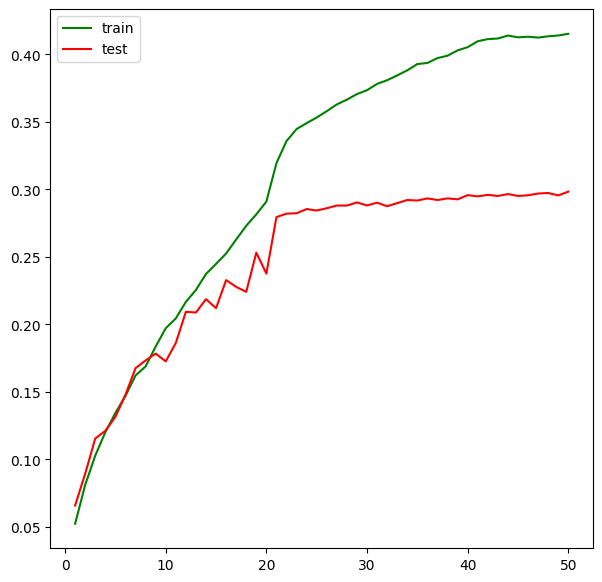

In [ ]:
plot(accuracy,EPOCH)

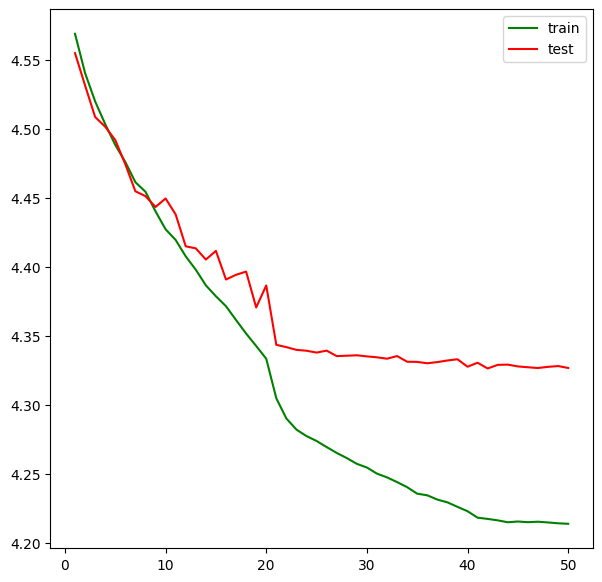

In [ ]:
plot(Loss,EPOCH)

In [ ]:
torch.save(dense_net,'dense_net_121_cifar_100.pt')